Instalação e imports

In [12]:
!pip -q install plotly==5.24.1 ucimlrepo==0.0.7 pandas==2.2.3 \
               scikit-learn==1.6.1 xgboost==3.0.4 \
               matplotlib==3.9.2

import warnings, json, os
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    ConfusionMatrixDisplay, RocCurveDisplay
)
from xgboost import XGBClassifier
import joblib


Carregar dataset

In [13]:
# Método 1: via ucimlrepo (oficial UCI)
from ucimlrepo import fetch_ucirepo
heart = fetch_ucirepo(id=45)  # Heart Disease
df = pd.concat([heart.data.features, heart.data.targets], axis=1)

# Padronizar a coluna-alvo para 'target' (0/1)
if 'target' in df.columns:
    pass
elif 'num' in df.columns:
    df['target'] = (df['num'] > 0).astype(int)
    df.drop(columns=['num'], inplace=True)
else:
    raise ValueError("Não encontrei coluna de alvo ('target' ou 'num').")

df = df.dropna(how="all").reset_index(drop=True)
df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


EDA rápida (histograma e boxplot interativos)

In [14]:
# Escolha uma coluna numérica para explorar:
num_cols = [c for c in df.columns if c != 'target' and np.issubdtype(df[c].dtype, np.number)]
col_hist = num_cols[0] if num_cols else None
col_box = num_cols[1] if len(num_cols) > 1 else col_hist

if col_hist:
    fig_h = px.histogram(df, x=col_hist, color='target', barmode='overlay', nbins=30,
                         title=f"Histograma: {col_hist} por target")
    fig_h.show()

if col_box:
    fig_b = px.box(df, x='target', y=col_box, points='all',
                   title=f"Boxplot: {col_box} vs target")
    fig_b.show()


Split, pipeline robusto a faltas e XGBoost

In [15]:
X = df.drop(columns=['target'])
y = df['target']

# (Opcional) forçar numéricos: muitos atributos são inteiros codificando categorias.
# Se quiser hot-encoding depois, dá para adaptar. Aqui vamos imputer numérico e deixar XGBoost lidar.
num_features = X.columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_features),
    ],
    remainder="drop",
)

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss",
    tree_method="hist",
)

model = Pipeline(steps=[("prep", preprocess), ("xgb", xgb)])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

model.fit(X_train, y_train)
pred = model.predict(X_test)
proba = model.predict_proba(X_test)[:, 1]

print("Accuracy:", round(accuracy_score(y_test, pred), 4))
print("ROC AUC:", round(roc_auc_score(y_test, proba), 4))
print(classification_report(y_test, pred))


Accuracy: 0.8289
ROC AUC: 0.9199
              precision    recall  f1-score   support

           0       0.87      0.80      0.84        41
           1       0.79      0.86      0.82        35

    accuracy                           0.83        76
   macro avg       0.83      0.83      0.83        76
weighted avg       0.83      0.83      0.83        76



Avaliações gráficas (matplotlib, simples)

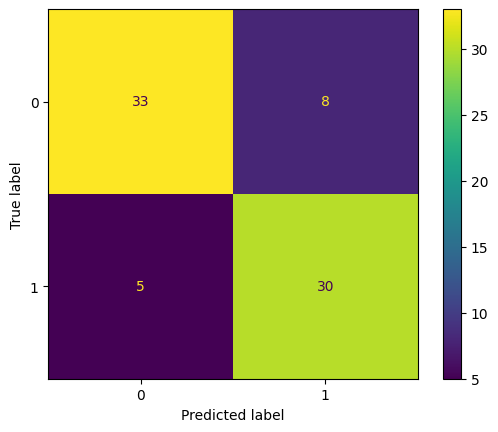

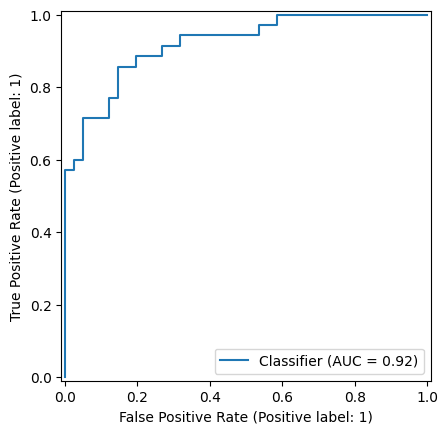

In [16]:
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_test, pred)
plt.show()

RocCurveDisplay.from_predictions(y_test, proba)
plt.show()


Teste de previsão com entradas incompletas (robustez)

In [17]:
ex = {c: np.nan for c in num_features}         # tudo faltando...
ex.update({"age": 54, "chol": 230})            # usuário só informou duas entradas
ex_df = pd.DataFrame([ex])[num_features]

print("Probabilidade de doença (%):", float(model.predict_proba(ex_df)[0,1]*100))
print("Classe prevista (0=saudável, 1=doença):", int(model.predict(ex_df)[0]))


Probabilidade de doença (%): 3.428795576095581
Classe prevista (0=saudável, 1=doença): 0


Exportar artefatos para o app (pasta models/)

In [18]:
os.makedirs("models", exist_ok=True)
joblib.dump(model, "models/heart_xgb.pkl")
with open("models/features.json", "w") as f:
    json.dump(num_features, f, indent=2)


Para baixar no Colab:

In [19]:
from google.colab import files
files.download("models/heart_xgb.pkl")
files.download("models/features.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>